(Chapter 4: Optimal Stopping)=
```{raw} jupyter
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```
# Chapter 4: Optimal Stopping


```{contents} Contents
:depth: 2
```



## firm_exit.py

In [1]:
"""
Firm valuation with exit option.

"""

from quantecon.markov import tauchen
from quantecon import compute_fixed_point

import numpy as np
from collections import namedtuple
from numba import njit


# NamedTuple Model
Model = namedtuple("Model", ("n", "z_vals", "Q", "β", "s"))


def create_exit_model(
        n=200,                  # productivity grid size
        ρ=0.95, μ=0.1, ν=0.1,   # persistence, mean and volatility
        β=0.98, s=100.0         # discount factor and scrap value
    ):
    """
    Creates an instance of the firm exit model.
    """
    mc = tauchen(n, ρ, ν, mu=μ)
    z_vals, Q = mc.state_values, mc.P
    return Model(n=n, z_vals=z_vals, Q=Q, β=β, s=s)


@njit
def no_exit_value(model):
    """Compute value of firm without exit option."""
    n, z_vals, Q, β, s = model
    I = np.identity(n)
    return np.linalg.solve((I - β * Q), z_vals)


@njit
def T(v, model):
    """The Bellman operator Tv = max{s, π + β Q v}."""
    n, z_vals, Q, β, s = model
    h = z_vals + β * np.dot(Q, v)
    return np.maximum(s, h)


@njit
def get_greedy(v, model):
    """Get a v-greedy policy."""
    n, z_vals, Q, β, s = model
    σ = s >= z_vals + β * np.dot(Q, v)
    return σ


def vfi(model):
    """Solve by VFI."""
    v_init = no_exit_value(model)
    v_star = compute_fixed_point(lambda v: T(v, model), v_init, error_tol=1e-6,
                                 max_iter=1000, print_skip=25)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star


# Plots


import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True, "font.size": 14})


def plot_val(savefig=False,
             figname="./figures/firm_exit_1.pdf"):

    fig, ax = plt.subplots(figsize=(9, 5.2))

    model = create_exit_model()
    n, z_vals, Q, β, s = model

    v_star, σ_star = vfi(model)
    h = z_vals + β * np.dot(Q, v_star)

    ax.plot(z_vals, h, "-", linewidth=3, alpha=0.6, label=r"$h^*$")
    ax.plot(z_vals, s * np.ones(n), "-", linewidth=3, alpha=0.6, label=r"$s$")
    ax.plot(z_vals, v_star, "k--", linewidth=1.5, alpha=0.8, label=r"$v^*$")

    ax.legend(frameon=False)
    ax.set_xlabel(r"$z$")

    if savefig:
        fig.savefig(figname)


def plot_comparison(savefig=False,
                    figname="./figures/firm_exit_2.pdf"):

    fig, ax = plt.subplots(figsize=(9, 5.2))

    model = create_exit_model()
    n, z_vals, Q, β, s = model

    v_star, σ_star = vfi(model)
    w = no_exit_value(model)

    ax.plot(z_vals, v_star, "k-", linewidth=2, alpha=0.6, label="$v^*$")
    ax.plot(z_vals, w, linewidth=2, alpha=0.6, label="no-exit value")

    ax.legend(frameon=False)
    ax.set_xlabel(r"$z$")

    if savefig:
        fig.savefig(figname)


Iteration    Distance       Elapsed (seconds)
---------------------------------------------


25           3.581e-02      7.223e-01         
50           1.723e-02      7.230e-01         
75           6.768e-03      7.236e-01         
100          2.643e-03      7.241e-01         
125          1.043e-03      7.247e-01         
150          4.139e-04      7.252e-01         
175          1.643e-04      7.258e-01         
200          6.522e-05      7.264e-01         
225          2.589e-05      7.269e-01         
250          1.028e-05      7.275e-01         
275          4.080e-06      7.280e-01         
300          1.619e-06      7.286e-01         
314          9.653e-07      7.289e-01         
Converged in 314 steps


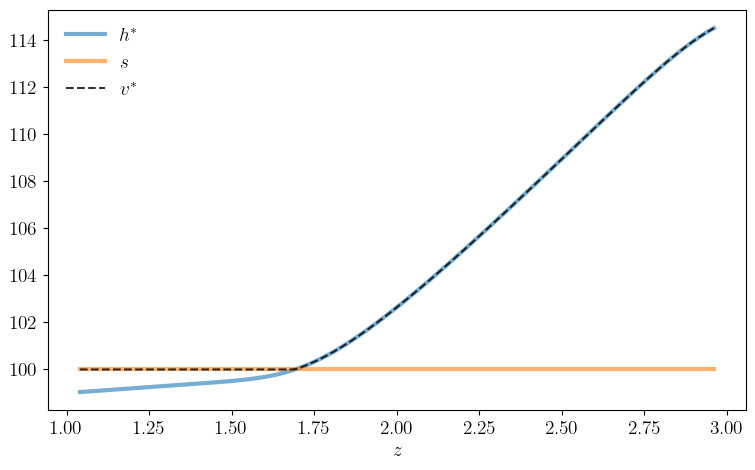

In [2]:
plot_val()

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
25           3.581e-02      8.829e-04         
50           1.723e-02      1.395e-03         
75           6.768e-03      1.881e-03         
100          2.643e-03      2.368e-03         
125          1.043e-03      2.853e-03         
150          4.139e-04      3.336e-03         
175          1.643e-04      3.823e-03         
200          6.522e-05      9.670e-03         
225          2.589e-05      1.016e-02         
250          1.028e-05      1.067e-02         
275          4.080e-06      1.125e-02         
300          1.619e-06      1.182e-02         
314          9.653e-07      1.215e-02         
Converged in 314 steps


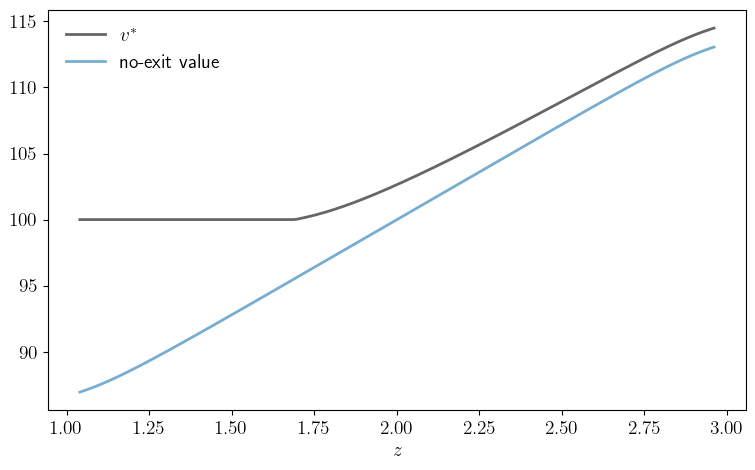

In [3]:
plot_comparison()

## american_option.py

In [4]:
"""
Valuation for finite-horizon American call options in discrete time.

"""

from quantecon.markov import tauchen, MarkovChain
from quantecon import compute_fixed_point

import numpy as np
from collections import namedtuple
from numba import njit, prange


# NamedTuple Model
Model = namedtuple("Model", ("t_vals", "z_vals","w_vals", "Q",
                             "φ", "T", "β", "K"))


@njit
def exit_reward(t, i_w, i_z, T, K):
    """Payoff to exercising the option at time t."""
    return (t < T) * (i_z + i_w - K)


def create_american_option_model(
        n=100, μ=10.0,   # Markov state grid size and mean value
        ρ=0.98, ν=0.2,   # persistence and volatility for Markov state
        s=0.3,           # volatility parameter for W_t
        r=0.01,          # interest rate
        K=10.0, T=200):  # strike price and expiration date
    """
    Creates an instance of the option model with log S_t = Z_t + W_t.
    """
    t_vals = np.arange(T+1)
    mc = tauchen(n, ρ, ν)
    z_vals, Q = mc.state_values + μ, mc.P
    w_vals, φ, β = np.array([-s, s]), np.array([0.5, 0.5]), 1 / (1 + r)
    return Model(t_vals=t_vals, z_vals=z_vals, w_vals=w_vals, Q=Q,
                φ=φ, T=T, β=β, K=K)


@njit(parallel=True)
def C(h, model):
    """The continuation value operator."""
    t_vals, z_vals, w_vals, Q, φ, T, β, K = model
    Ch = np.empty_like(h)
    z_idx, w_idx = np.arange(len(z_vals)), np.arange(len(w_vals))
    for i in prange(len(t_vals)):
        t = t_vals[i]
        for i_z in prange(len(z_vals)):
            out = 0.0
            for i_w_1 in prange(len(w_vals)):
                for i_z_1 in prange(len(z_vals)):
                    t_1 = min(t + 1, T)
                    out += max(exit_reward(t_1, w_vals[i_w_1], z_vals[i_z_1], T, K),
                                h[t_1, i_z_1]) * Q[i_z, i_z_1] * φ[i_w_1]
            Ch[t, i_z] = β * out

    return Ch


def compute_cvf(model):
    """
    Compute the continuation value function by successive approx.
    """
    h_init = np.zeros((len(model.t_vals), len(model.z_vals)))
    h_star = compute_fixed_point(lambda h: C(h, model), h_init,
                                 error_tol=1e-6, max_iter=1000,
                                 print_skip=25)
    return h_star


# Plots


import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True, "font.size": 14})


def plot_contours(savefig=False,
                  figname="./figures/american_option_1.pdf"):

    model = create_american_option_model()
    t_vals, z_vals, w_vals, Q, φ, T, β, K = model
    h_star = compute_cvf(model)
    fig, axes = plt.subplots(3, 1, figsize=(7, 11))
    z_idx, w_idx = np.arange(len(z_vals)), np.arange(len(w_vals))
    H = np.zeros((len(w_vals), len(z_vals)))
    for (ax_index, t) in zip(range(3), (1, 195, 198)):

        ax = axes[ax_index]
        for i_w in prange(len(w_vals)):
            for i_z in prange(len(z_vals)):
                H[i_w, i_z] = exit_reward(t, w_vals[i_w], z_vals[i_z], T,
                                          K) - h_star[t, i_z]

        cs1 = ax.contourf(w_vals, z_vals, np.transpose(H), alpha=0.5)
        ctr1 = ax.contour(w_vals, z_vals, np.transpose(H), levels=[0.0])
        plt.clabel(ctr1, inline=1, fontsize=13)
        plt.colorbar(cs1, ax=ax)

        ax.set_title(f"$t={t}$")
        ax.set_xlabel(r"$w$")
        ax.set_ylabel(r"$z$")

    fig.tight_layout()
    if savefig:
        fig.savefig(figname)


def plot_strike(savefig=False,
                fontsize=9,
                figname="./figures/american_option_2.pdf"):
    model = create_american_option_model()
    t_vals, z_vals, w_vals, Q, φ, T, β, K = model
    h_star = compute_cvf(model)

    # Built Markov chains for simulation
    z_mc = MarkovChain(Q, z_vals)
    P_φ = np.zeros((len(w_vals), len(w_vals)))
    for i in range(len(w_vals)):  # Build IID chain
        P_φ[i, :] = φ
    w_mc = MarkovChain(P_φ, w_vals)
    y_min = np.min(z_vals) + np.min(w_vals)
    y_max = np.max(z_vals) + np.max(w_vals)
    fig, axes = plt.subplots(3, 1, figsize=(7, 12))

    for ax in axes:

        # Generate price series
        z_draws = z_mc.simulate_indices(T, init=int(len(z_vals) / 2 - 10))
        w_draws = w_mc.simulate_indices(T)
        s_vals = z_vals[z_draws] + w_vals[w_draws]

        # Find the exercise date, if any.
        exercise_date = T + 1
        for t in range(T):
            k = exit_reward(t, w_vals[w_draws[t]], z_vals[z_draws[t]], T, K) - \
                    h_star[w_draws[t], z_draws[t]]
            if k >= 0:
                exercise_date = t

        if exercise_date >= T:
            print("Warning: Option not exercised.")
        else:
            # Plot
            ax.set_ylim(y_min, y_max)
            ax.set_xlim(0, T+1)
            ax.fill_between(range(T), np.ones(T) * K, np.ones(T) * y_max, alpha=0.2)
            ax.plot(range(T), s_vals, label=r"$S_t$")
            ax.plot((exercise_date,), (s_vals[exercise_date]), "ko")
            ax.vlines((exercise_date,), 0, (s_vals[exercise_date]), ls="--", colors="black")
            ax.legend(loc="upper left", fontsize=fontsize)
            ax.text(-10, 11, "in the money", fontsize=fontsize, rotation=90)
            ax.text(-10, 7.2, "out of the money", fontsize=fontsize, rotation=90)
            ax.text(exercise_date-20, 6,
                    "exercise date", fontsize=fontsize)
            ax.set_xticks((1, T))
            ax.set_yticks((y_min, y_max))

    if savefig:
        fig.savefig(figname)


Iteration    Distance       Elapsed (seconds)
---------------------------------------------


25           6.682e-03      1.536e+00         
50           3.997e-03      1.621e+00         
75           2.923e-03      1.705e+00         


100          1.960e-03      1.792e+00         
125          1.242e-03      1.878e+00         
150          7.739e-04      1.963e+00         


175          4.811e-04      2.050e+00         
200          0.000e+00      2.140e+00         
Converged in 200 steps


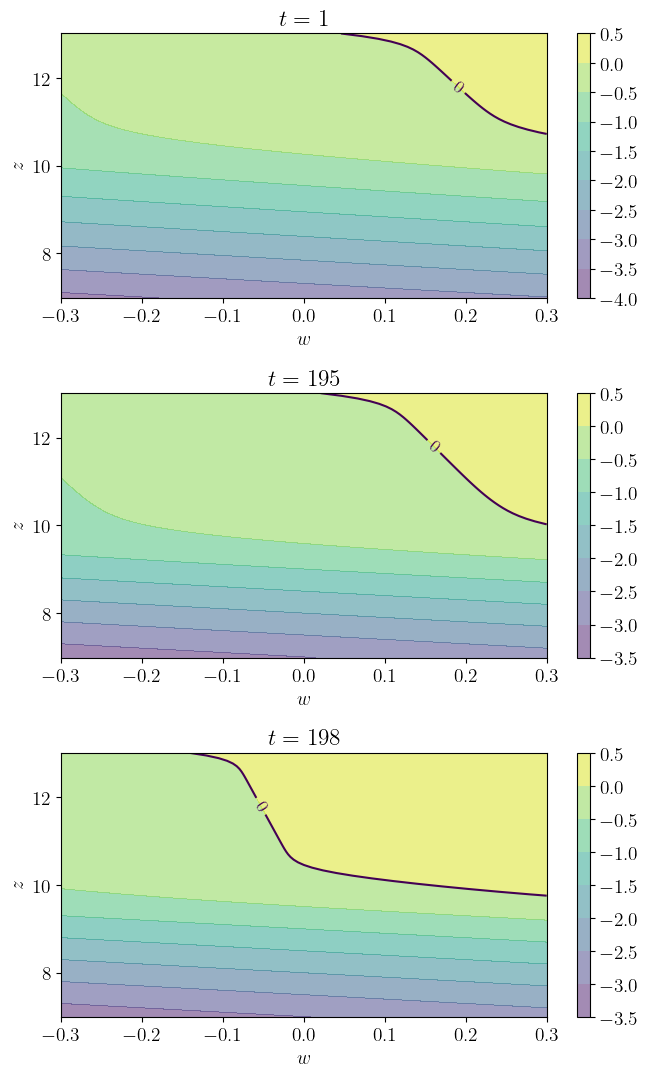

In [5]:
plot_contours()

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
25           6.682e-03      8.690e-02         
50           3.997e-03      1.713e-01         


75           2.923e-03      2.609e-01         
100          1.960e-03      3.432e-01         
125          1.242e-03      4.258e-01         


150          7.739e-04      5.100e-01         
175          4.811e-04      5.925e-01         
200          0.000e+00      6.750e-01         
Converged in 200 steps


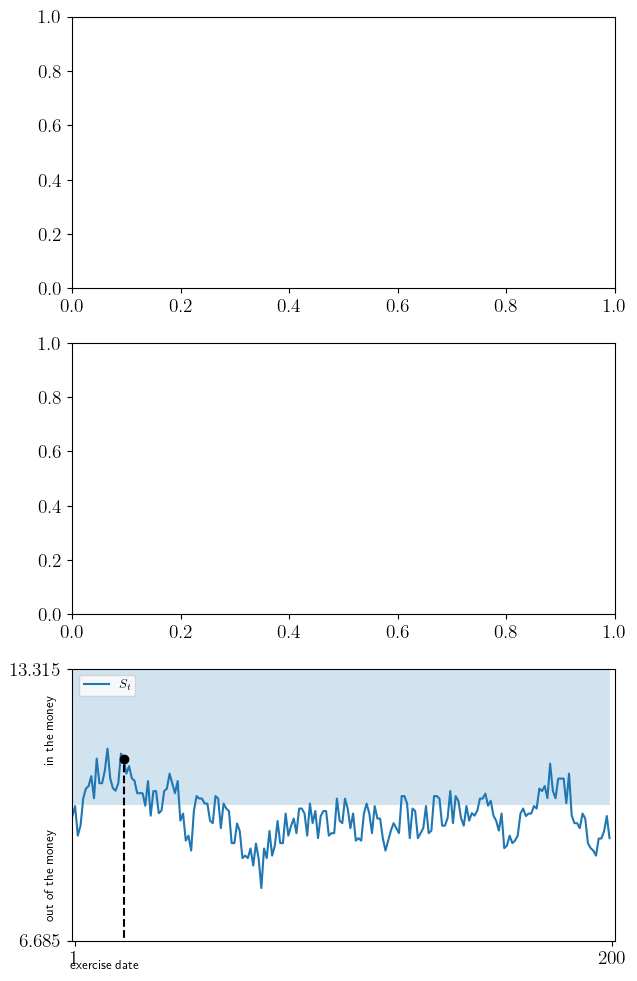

In [6]:
plot_strike()